# TP1 - Analyzing New York City Taxi Data
By Welfi Kharroubi & Tanaz Piriaei

## Imports

In [ ]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

%matplotlib inline
plt.style.use('ggplot')

In [2]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


We kick off our project with initiating a Spark session called "pyspark-nyc-taxi-data-analysis".

In [3]:
spark = SparkSession.\
        builder.\
        appName("pyspark-nyc-taxi-data-analysis").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "512m").\
        getOrCreate()

24/10/21 15:54:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
sc = spark.sparkContext

## Reading the data

In [5]:
### NYC Taxi data

In [6]:
data = spark.read.csv(path="Sample_NYC_Data.csv", sep=",", header=True)

In [7]:
data.head(5)

[Row(medallion='89D227B655E5C82AECF13C3F540D4CF4', hack_license='BA96DE419E711691B9445D6A6307C170', vendor_id='CMT', rate_code='1', store_and_fwd_flag='N', pickup_datetime='01-01-13 15:11', dropoff_datetime='01-01-13 15:18', passenger_count='4', pickup_longitude='-73.978165', pickup_latitude='40.757977', dropoff_longitude='-73.989838', dropoff_latitude='40.751171'),
 Row(medallion='0BD7C8F5BA12B88E0B67BED28BEA73D8', hack_license='9FD8F69F0804BDB5549F40E9DA1BE472', vendor_id='CMT', rate_code='1', store_and_fwd_flag='N', pickup_datetime='06-01-13 00:18', dropoff_datetime='06-01-13 00:22', passenger_count='1', pickup_longitude='-74.006683', pickup_latitude='40.731781', dropoff_longitude='-73.994499', dropoff_latitude='40.75066'),
 Row(medallion='0BD7C8F5BA12B88E0B67BED28BEA73D8', hack_license='9FD8F69F0804BDB5549F40E9DA1BE472', vendor_id='CMT', rate_code='1', store_and_fwd_flag='N', pickup_datetime='05-01-13 18:49', dropoff_datetime='05-01-13 18:54', passenger_count='1', pickup_longitude=

In [8]:
data.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)



We have 13 columns in total, all the columns are nullable and they are in string format.

### GeoJSON data
We load and process GeoJSON data containing information about NYC boroughs. First, we open the GeoJSON file, nyc-boroughs.geojson, and parse its contents using Python's json module. For each borough, we extract the borough name and its geographic bounding box. Specifically, we gather the minimum and maximum longitude and latitude values from the coordinates in each feature's geometry (assuming each borough is represented as a polygon). This data is stored in boroughs_bounding_boxes as a list of dictionaries, each holding the name and bounding box coordinates for a borough.

In [10]:
import json

# Load GeoJSON data for boroughs
with open("nyc-boroughs.geojson", "r") as f:
    geojson_data = json.load(f)

# Extract borough name and bounding boxes (min/max longitude and latitude)
boroughs_bounding_boxes = []
for feature in geojson_data['features']:
    borough_name = feature['properties']['borough']  # Adjust based on GeoJSON
    coordinates = feature['geometry']['coordinates'][0]  # Assuming polygons
    lons, lats = zip(*coordinates)
    min_lon, max_lon = min(lons), max(lons)
    min_lat, max_lat = min(lats), max(lats)
    boroughs_bounding_boxes.append({
        "borough_name": borough_name,
        "min_lon": min_lon,
        "max_lon": max_lon,
        "min_lat": min_lat,
        "max_lat": max_lat
    })

In [11]:
# Broadcast the bounding boxes to Spark workers
broadcast_bounding_boxes = spark.sparkContext.broadcast(boroughs_bounding_boxes)

we define a User-Defined Function (UDF) to determine the borough for a given longitude and latitude pair. The get_borough function takes these coordinates as input, converts them to floating-point numbers, and iterates through a broadcasted list of borough bounding boxes (broadcast_bounding_boxes.value). For each borough, it checks if the input coordinates fall within the borough's bounding box. If a match is found, the borough’s name is returned; if the coordinates are invalid or don’t match any borough, the function returns None. We register this function as a Spark UDF (get_borough_udf), allowing us to apply it on Spark DataFrames.

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# UDF to determine the borough for a given latitude/longitude
def get_borough(longitude, latitude):
    try:
        # Convert longitude and latitude to floats
        lon = float(longitude)
        lat = float(latitude)
        
        boroughs = broadcast_bounding_boxes.value
        for borough in boroughs:
            if (borough['min_lon'] <= lon <= borough['max_lon'] and
                borough['min_lat'] <= lat <= borough['max_lat']):
                return borough['borough_name']
    except (TypeError, ValueError):
        # In case of invalid data (e.g., missing or malformed coordinates), return None
        return None
    return None

# Register the UDF with Spark
get_borough_udf = F.udf(get_borough, StringType())

We are applying the UDFs to our data in order to create the resulting DataFrame.

In [ ]:
# Add pickup and dropoff boroughs to the taxi DataFrame
taxi_data_with_boroughs = data.withColumn(
    "pickup_borough", get_borough_udf(data["pickup_longitude"], data["pickup_latitude"])
).withColumn(
    "dropoff_borough", get_borough_udf(data["dropoff_longitude"], data["dropoff_latitude"])
)

# Show the resulting DataFrame
taxi_data_with_boroughs.show(truncate=False)

+--------------------------------+--------------------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+--------------+---------------+
|medallion                       |hack_license                    |vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|pickup_borough|dropoff_borough|
+--------------------------------+--------------------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+--------------+---------------+
|89D227B655E5C82AECF13C3F540D4CF4|BA96DE419E711691B9445D6A6307C170|CMT      |1        |N                 |01-01-13 15:11 |01-01-13 15:18  |4              |-73.978165      |40.757977      |-73.989838       |40.751171       |Manhattan   

In this cell, we add Unix timestamp columns to represent pickup and dropoff times in the dataset. Using unix_timestamp, we convert the pickup_datetime and dropoff_datetime columns into Unix timestamps based on the format "MM-dd-yy HH:mm". Then, we calculate the trip duration in milliseconds by subtracting the pickup timestamp from the dropoff timestamp and multiplying by 1000, storing the result in a new duration column. Finally, we display the pickup_datetime, dropoff_datetime, and duration columns to verify the calculation.

In [ ]:
from pyspark.sql import functions as F

# Convert pickup and dropoff datetime columns to Unix timestamps
data_with_timestamps = taxi_data_with_boroughs.withColumn(
    "pickup_timestamp", F.unix_timestamp("pickup_datetime", "MM-dd-yy HH:mm")
).withColumn(
    "dropoff_timestamp", F.unix_timestamp("dropoff_datetime", "MM-dd-yy HH:mm")
)

# Calculate the trip duration in milliseconds (dropoff - pickup) * 1000
data_with_duration = data_with_timestamps.withColumn(
    "duration", (F.col("dropoff_timestamp") - F.col("pickup_timestamp")) * 1000
)

# Show the resulting DataFrame with the new duration column
data_with_duration.select("pickup_datetime", "dropoff_datetime", "duration").show(truncate=False)

+---------------+----------------+--------+
|pickup_datetime|dropoff_datetime|duration|
+---------------+----------------+--------+
|01-01-13 15:11 |01-01-13 15:18  |420000  |
|06-01-13 00:18 |06-01-13 00:22  |240000  |
|05-01-13 18:49 |05-01-13 18:54  |300000  |
|07-01-13 23:54 |07-01-13 23:58  |240000  |
|07-01-13 23:25 |07-01-13 23:34  |540000  |
|07-01-13 15:27 |07-01-13 15:38  |660000  |
|08-01-13 11:01 |08-01-13 11:08  |420000  |
|07-01-13 12:39 |07-01-13 13:10  |1860000 |
|07-01-13 18:15 |07-01-13 18:20  |300000  |
|07-01-13 15:33 |07-01-13 15:49  |960000  |
|08-01-13 13:11 |08-01-13 13:19  |480000  |
|08-01-13 09:50 |08-01-13 10:02  |720000  |
|10-01-13 12:07 |10-01-13 12:17  |600000  |
|07-01-13 07:35 |07-01-13 07:46  |660000  |
|10-01-13 15:42 |10-01-13 16:04  |1320000 |
|10-01-13 14:27 |10-01-13 14:45  |1080000 |
|07-01-13 22:09 |07-01-13 22:19  |600000  |
|07-01-13 17:18 |07-01-13 17:20  |120000  |
|07-01-13 06:08 |07-01-13 06:13  |300000  |
|07-01-13 22:25 |07-01-13 22:36 

In [17]:
# Keep only trips with positive duration and duration under 4 hours (14400000 milliseconds)
filtered_data = data_with_duration.filter((F.col("duration") > 0) & (F.col("duration") < 14400000))

# Show the filtered data
filtered_data.select("pickup_datetime", "dropoff_datetime", "duration").show(truncate=False)

+---------------+----------------+--------+
|pickup_datetime|dropoff_datetime|duration|
+---------------+----------------+--------+
|01-01-13 15:11 |01-01-13 15:18  |420000  |
|06-01-13 00:18 |06-01-13 00:22  |240000  |
|05-01-13 18:49 |05-01-13 18:54  |300000  |
|07-01-13 23:54 |07-01-13 23:58  |240000  |
|07-01-13 23:25 |07-01-13 23:34  |540000  |
|07-01-13 15:27 |07-01-13 15:38  |660000  |
|08-01-13 11:01 |08-01-13 11:08  |420000  |
|07-01-13 12:39 |07-01-13 13:10  |1860000 |
|07-01-13 18:15 |07-01-13 18:20  |300000  |
|07-01-13 15:33 |07-01-13 15:49  |960000  |
|08-01-13 13:11 |08-01-13 13:19  |480000  |
|08-01-13 09:50 |08-01-13 10:02  |720000  |
|10-01-13 12:07 |10-01-13 12:17  |600000  |
|07-01-13 07:35 |07-01-13 07:46  |660000  |
|10-01-13 15:42 |10-01-13 16:04  |1320000 |
|10-01-13 14:27 |10-01-13 14:45  |1080000 |
|07-01-13 22:09 |07-01-13 22:19  |600000  |
|07-01-13 17:18 |07-01-13 17:20  |120000  |
|07-01-13 06:08 |07-01-13 06:13  |300000  |
|07-01-13 22:25 |07-01-13 22:36 

In [18]:
# Get descriptive statistics for the duration column
duration_stats = filtered_data.describe("duration")
duration_stats.show()

+-------+-----------------+
|summary|         duration|
+-------+-----------------+
|  count|              237|
|   mean|721518.9873417722|
| stddev|591084.3710910676|
|    min|            60000|
|    max|          3060000|
+-------+-----------------+



Now we convert the filtered_data Spark DataFrame to a Pandas DataFrame (filtered_data_pd) to enable easy plotting with Matplotlib and Seaborn. We focus on visualizing the duration column, which represents trip durations in milliseconds. First, we create a histogram to show the distribution of trip durations (converting milliseconds to minutes by dividing by 60,000) and overlay a kernel density estimate (KDE) for a smoother distribution curve. Then, we use a box plot to help identify any outliers in the trip durations. Both plots provide insights into the range and variation of trip times.

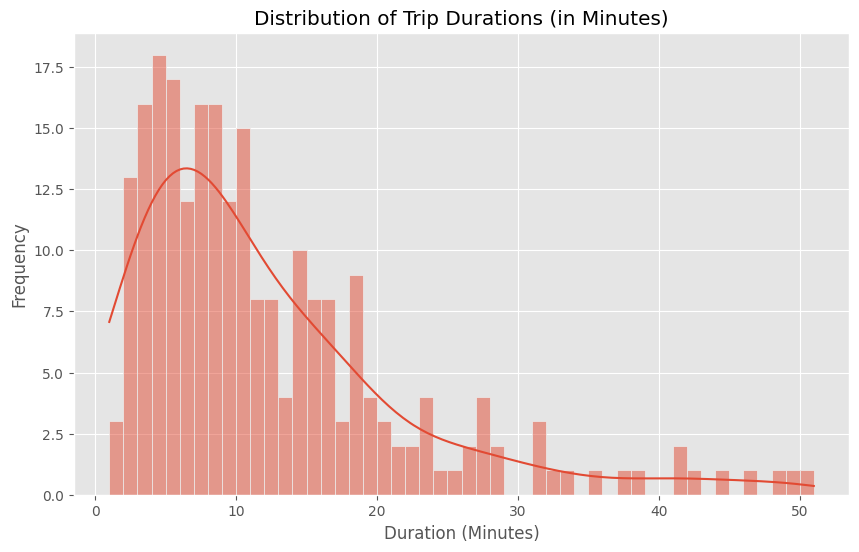

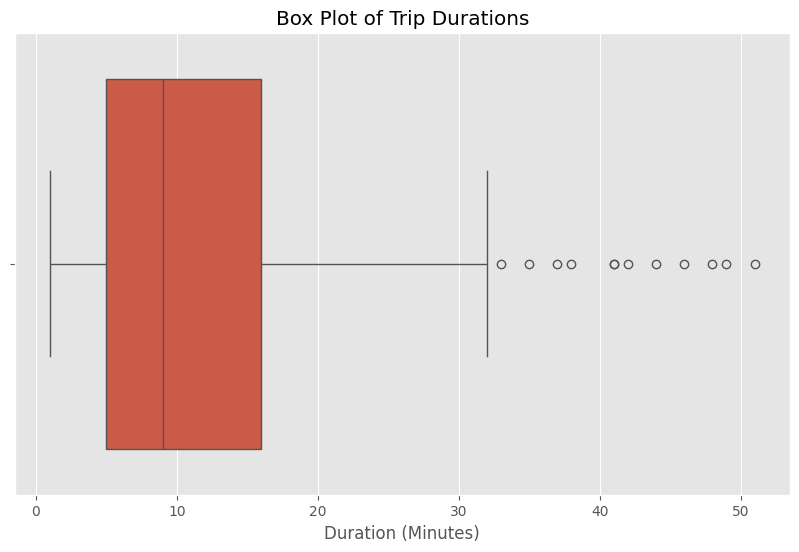

In [24]:
# Convert the filtered DataFrame to a Pandas DataFrame for plotting
filtered_data_pd = filtered_data.select("duration").toPandas()

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of trip durations
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data_pd["duration"] / 60000, bins=50, kde=True)  # Convert to minutes
plt.title("Distribution of Trip Durations (in Minutes)")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Frequency")
plt.show()

# Plot a box plot to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_data_pd["duration"] / 60000)  # Convert to minutes
plt.title("Box Plot of Trip Durations")
plt.xlabel("Duration (Minutes)")
plt.show()

Next, we convert the passenger_count column to an integer type for consistency and accurate analysis. We then calculate descriptive statistics by grouping the data by passenger_count and counting the occurrences of each value, displaying the results in descending order. Afterward, we visualize the distribution of passenger counts by converting the Spark DataFrame to Pandas (passenger_count_pd). Using Seaborn, we create a count plot to illustrate the frequency of each passenger count, giving insight into typical passenger numbers in the dataset.
We notice that the most frequent number of passengers is 1.

+---------------+-----+
|passenger_count|count|
+---------------+-----+
|              1|  173|
|              2|   38|
|              3|    9|
|              5|    8|
|              6|    5|
|              4|    4|
+---------------+-----+



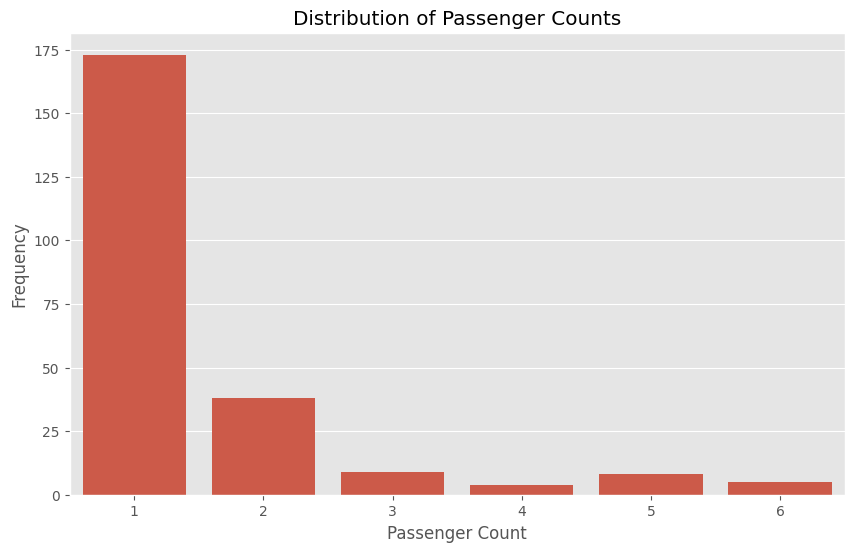

In [25]:
# Convert the passenger_count column to an integer
filtered_data = filtered_data.withColumn("passenger_count", F.col("passenger_count").cast("int"))

# Generate descriptive statistics for passenger counts
filtered_data.groupBy("passenger_count").count().orderBy("count", ascending=False).show()

# Visualize the distribution of passenger counts
passenger_count_pd = filtered_data.select("passenger_count").toPandas()

plt.figure(figsize=(10, 6))
sns.countplot(x="passenger_count", data=passenger_count_pd)
plt.title("Distribution of Passenger Counts")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.show()

In this cell, we begin by converting the pickup_datetime column from a string to a timestamp type using to_timestamp, which ensures accurate time-based analysis. Next, we extract the hour component from the pickup_timestamp and store it in a new column called pickup_hour. This transformation allows us to analyze patterns in trip pickups based on the time of day. Finally, we display the pickup_datetime and pickup_hour columns to verify the results.

In [27]:
from pyspark.sql import functions as F

# Step 1: Convert `pickup_datetime` string to `timestamp` type
data_with_timestamp = filtered_data.withColumn(
    "pickup_timestamp", F.to_timestamp(F.col("pickup_datetime"), "MM-dd-yy HH:mm")
)

# Step 2: Extract the hour from the `pickup_timestamp`
data_with_hour = data_with_timestamp.withColumn("pickup_hour", F.hour(F.col("pickup_timestamp")))

# Show the updated DataFrame with `pickup_hour`
data_with_hour.select("pickup_datetime", "pickup_hour").show(truncate=False)

+---------------+-----------+
|pickup_datetime|pickup_hour|
+---------------+-----------+
|01-01-13 15:11 |15         |
|06-01-13 00:18 |0          |
|05-01-13 18:49 |18         |
|07-01-13 23:54 |23         |
|07-01-13 23:25 |23         |
|07-01-13 15:27 |15         |
|08-01-13 11:01 |11         |
|07-01-13 12:39 |12         |
|07-01-13 18:15 |18         |
|07-01-13 15:33 |15         |
|08-01-13 13:11 |13         |
|08-01-13 09:50 |9          |
|10-01-13 12:07 |12         |
|07-01-13 07:35 |7          |
|10-01-13 15:42 |15         |
|10-01-13 14:27 |14         |
|07-01-13 22:09 |22         |
|07-01-13 17:18 |17         |
|07-01-13 06:08 |6          |
|07-01-13 22:25 |22         |
+---------------+-----------+
only showing top 20 rows



In this cell, we group the data by pickup_hour to count the number of trips per hour and then convert the result to a Pandas DataFrame for plotting. Using Seaborn, we create a bar plot to visualize the hourly distribution of trips, helping to identify peak hours for pickups.

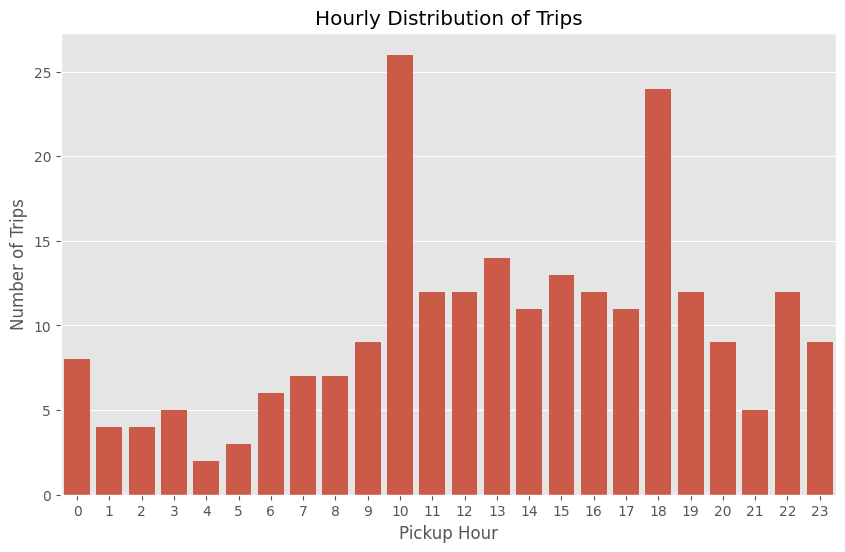

In [28]:
# Group by hour and count the number of trips
hourly_trip_counts = data_with_hour.groupBy("pickup_hour").count().orderBy("pickup_hour")

# Convert to Pandas for plotting
hourly_trip_counts_pd = hourly_trip_counts.toPandas()

# Plot hourly distribution of trips
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="pickup_hour", y="count", data=hourly_trip_counts_pd)
plt.title("Hourly Distribution of Trips")
plt.xlabel("Pickup Hour")
plt.ylabel("Number of Trips")
plt.show()

We notice that rush hours are 10AM and 6PM.

In [29]:
# Repartition the data by taxiID to ensure all trips for a taxi are processed together
shuffled_data = data_with_duration.repartition("medallion")

In this cell, we define a window specification to analyze trips for each taxi (medallion) in chronological order by pickup_timestamp. Using this window, we calculate the prev_dropoff time for each trip by applying the lag function. This adds a column with the timestamp of the previous trip’s dropoff, which can help analyze gaps or downtime between trips for each taxi.

In [30]:
from pyspark.sql import Window
import pyspark.sql.functions as F

# Define a window partitioned by taxiID and ordered by pickup time
window_spec = Window.partitionBy("medallion").orderBy("pickup_timestamp")

# Calculate the previous dropoff time (lag) for each taxi
data_with_lag = shuffled_data.withColumn("prev_dropoff", F.lag("dropoff_timestamp").over(window_spec))

In [31]:
# Calculate the idle time in seconds
data_with_idle_time = data_with_lag.withColumn(
    "idle_time", 
    (F.col("pickup_timestamp").cast("long") - F.col("prev_dropoff").cast("long"))
)

# Convert idle time to milliseconds
data_with_idle_time = data_with_idle_time.withColumn("idle_time_ms", F.col("idle_time") * 1000)

In [32]:
# Filter out new sessions where the idle time exceeds 4 hours (14400 seconds)
data_filtered = data_with_idle_time.filter((F.col("idle_time") > 0) & (F.col("idle_time") <= 14400))

In [33]:
# Group by taxiID (medallion) and sum the idle time
total_idle_time = data_filtered.groupBy("medallion").agg(F.sum("idle_time_ms").alias("total_idle_time_ms"))

# Show the results
total_idle_time.show(truncate=False)

+--------------------------------+------------------+
|medallion                       |total_idle_time_ms|
+--------------------------------+------------------+
|764CA5AE502C0FEC9BB69DBCB6BB4ECC|3240000           |
|DDB3F3E0172B1FBF0C9E39CA773CC6E3|12360000          |
|4728FA63A46613319446ED726626FED3|12000000          |
|82420BD631D2BB88E2F213A8CA15BECE|840000            |
|AA49129321B8D4FFE890CFDA2FBC1E8D|3000000           |
|FAE1370A694D0621FAE1E62FAFD64080|6060000           |
|961D9C9506D105D3A7E88229F0487033|4080000           |
|24929E5F008DBC4C0E551B957F619910|16020000          |
|26B6CDD419985C6F551F0FAE87EF3AA9|180000            |
|E12F6AF991172EAC3553144A0AF75A19|17940000          |
|78FFD9CD0CDA541F335EF8B38FB494D6|7500000           |
|D5367E940A20B9D2550BF7CF7AE01681|9120000           |
|2D4B95E2FA7B2E85118EC5CA4570FA58|8040000           |
|E9BA494DC1A1F26D186394EFBB8327CF|6000000           |
|FA3DD236E7627E99646337C5218EA281|7260000           |
|0B57B9633A2FECD3D3B1944AFC7

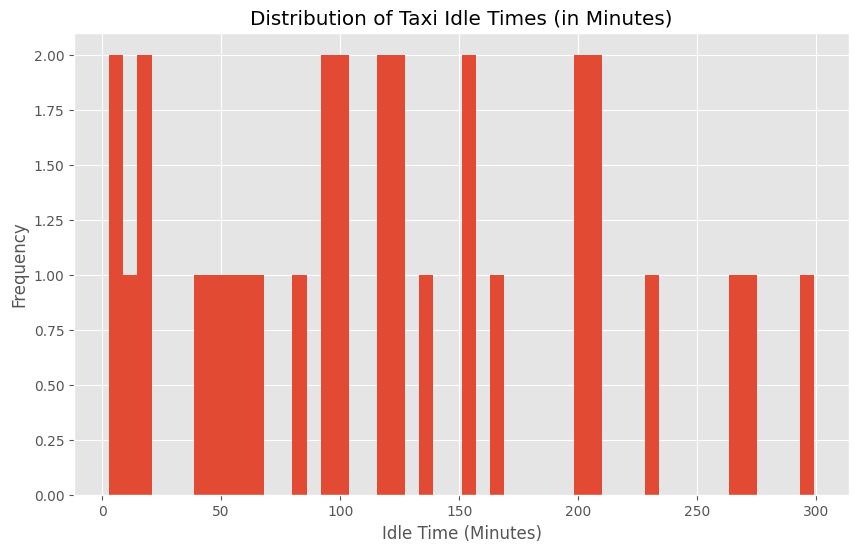

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas for visualization
total_idle_time_pd = total_idle_time.toPandas()

# Plotting the idle times
plt.figure(figsize=(10, 6))
plt.hist(total_idle_time_pd["total_idle_time_ms"] / 60000, bins=50)  # Convert to minutes
plt.title("Distribution of Taxi Idle Times (in Minutes)")
plt.xlabel("Idle Time (Minutes)")
plt.ylabel("Frequency")
plt.show()

In [36]:
# Shuffle and sort by taxiID and pickup time
window_spec = Window.partitionBy("medallion").orderBy("pickup_timestamp")

# Calculate the idle time for each taxi
data_with_lag = data_filtered.withColumn("prev_dropoff", F.lag("dropoff_timestamp").over(window_spec))

# Compute idle time (in seconds)
data_with_idle_time = data_with_lag.withColumn("idle_time", 
                                               (F.col("pickup_timestamp").cast("long") - 
                                                F.col("prev_dropoff").cast("long")))

# Filter out new sessions (idle times longer than 4 hours)
filtered_idle_times = data_with_idle_time.filter((F.col("idle_time") > 0) & (F.col("idle_time") <= 14400))

# Group by taxiID and sum the idle time
taxi_utilization = filtered_idle_times.groupBy("medallion").agg(F.sum("idle_time").alias("total_idle_time"))

# Show results
taxi_utilization.show()

+--------------------+---------------+
|           medallion|total_idle_time|
+--------------------+---------------+
|DDB3F3E0172B1FBF0...|           6960|
|AA49129321B8D4FFE...|           1560|
|961D9C9506D105D3A...|           2880|
|24929E5F008DBC4C0...|           6720|
|E12F6AF991172EAC3...|           6600|
|78FFD9CD0CDA541F3...|           7320|
|2D4B95E2FA7B2E851...|            900|
|0B57B9633A2FECD3D...|           5280|
|CD847FE5884F10A28...|           3600|
|B14118AD4BF381D80...|           3900|
|0C5296F3C8B16E702...|            180|
|50296A056AF5D2215...|            480|
|A5A69FAD94C3DC785...|           9300|
|4C005EEBAA7BF26B8...|           2220|
+--------------------+---------------+



In this cell, we first define a window to analyze each taxi’s trips based on dropoff_timestamp to find the next pickup time using the lead function. We then calculate the time difference between the current trip's dropoff and the next pickup, storing this in the time_to_next_fare column. After filtering for reasonable time differences (less than 4 hours), we group the data by dropoff_borough and compute the average time to the next fare. Finally, we display the average time for each destination borough, providing insights into how quickly taxis can find their next passenger.

In [38]:
# Use a Window partitioned by taxi and ordered by dropoff time to get the next pickup
window_spec_next = Window.partitionBy("medallion").orderBy("dropoff_timestamp")

# Calculate the pickup time of the next trip
data_with_next_pickup = data_filtered.withColumn("next_pickup", F.lead("pickup_timestamp").over(window_spec_next))

# Calculate time difference between the current dropoff and the next pickup
data_with_next_fare_time = data_with_next_pickup.withColumn(
    "time_to_next_fare", 
    (F.col("next_pickup").cast("long") - F.col("dropoff_timestamp").cast("long"))
)

# Filter trips with reasonable time differences (e.g., less than 4 hours)
valid_next_fares = data_with_next_fare_time.filter(F.col("time_to_next_fare") <= 14400)

# Group by destination borough and compute the average time to find the next fare
avg_next_fare_time = valid_next_fares.groupBy("dropoff_borough").agg(
    F.avg("time_to_next_fare").alias("avg_time_to_next_fare")
)

# Show the result
avg_next_fare_time.show()

+---------------+---------------------+
|dropoff_borough|avg_time_to_next_fare|
+---------------+---------------------+
|         Queens|               3120.0|
|           null|               6960.0|
|       Brooklyn|               1560.0|
|      Manhattan|   2858.5714285714284|
+---------------+---------------------+



In [39]:
# Filter trips where pickup and dropoff boroughs are the same
same_borough_trips = data_filtered.filter(F.col("pickup_borough") == F.col("dropoff_borough"))

# Count the number of trips for each borough
same_borough_count = same_borough_trips.groupBy("pickup_borough").count()

# Show the result
same_borough_count.show()

+--------------+-----+
|pickup_borough|count|
+--------------+-----+
|        Queens|    1|
|      Brooklyn|    2|
|     Manhattan|   20|
+--------------+-----+



In [40]:
# Filter trips where pickup and dropoff boroughs are different
different_borough_trips = data_filtered.filter(F.col("pickup_borough") != F.col("dropoff_borough"))

# Count the number of trips
different_borough_count = different_borough_trips.count()

# Show the result
print(f"Number of trips that started and ended in different boroughs: {different_borough_count}")

Number of trips that started and ended in different boroughs: 24


In [43]:
from pyspark.sql import functions as F

# Convert pickup and dropoff latitude and longitude to floats
data_with_floats = data.withColumn("pickup_longitude", F.col("pickup_longitude").cast("float")) \
                       .withColumn("pickup_latitude", F.col("pickup_latitude").cast("float")) \
                       .withColumn("dropoff_longitude", F.col("dropoff_longitude").cast("float")) \
                       .withColumn("dropoff_latitude", F.col("dropoff_latitude").cast("float"))

# Show the schema to verify the conversions
data_with_floats.printSchema()

# Show a sample of the converted data
data_with_floats.select("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude").show(5)

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)

+----------------+---------------+-----------------+----------------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+----------------+---------------+-----------------+----------------+
|      -73.978165|      40.757977|        -73.98984|        40.75117|
|       -74.00668|       40.73178|         -73.9945|        40.75066|
|       -74.00471|       40.73777|       -74.009834|          40.726|
|        -73.9746|      40.

We use VectorAssembler from PySpark’s ML library to create a feature vector for clustering based on pickup coordinates. We specify pickup_longitude and pickup_latitude as the input columns and define a new column named features to store the resulting vectors. We then apply the assembler to the dataset, transforming it to include the feature vectors. Finally, we display a sample of the dataset, showcasing the original pickup coordinates alongside the newly created features column.

In [44]:
from pyspark.ml.feature import VectorAssembler

# Create a vector for clustering based on pickup longitude and latitude
assembler = VectorAssembler(inputCols=["pickup_longitude", "pickup_latitude"], outputCol="features")

# Apply the assembler to the dataset
data_with_features = assembler.transform(data_with_floats)

# Show a sample with the new features column
data_with_features.select("pickup_longitude", "pickup_latitude", "features").show(5)

+----------------+---------------+--------------------+
|pickup_longitude|pickup_latitude|            features|
+----------------+---------------+--------------------+
|      -73.978165|      40.757977|[-73.978164672851...|
|       -74.00668|       40.73178|[-74.006683349609...|
|       -74.00471|       40.73777|[-74.004707336425...|
|        -73.9746|      40.759945|[-73.974601745605...|
|       -73.97625|      40.748528|[-73.976249694824...|
+----------------+---------------+--------------------+
only showing top 5 rows



Here, we initialize a KMeans clustering model with a specified number of clusters (k=5) and a random seed for reproducibility. We fit the model to the dataset containing the feature vectors created earlier. After fitting, we transform the data to include cluster predictions for each record, which indicates the assigned cluster based on pickup locations. We then display the longitude and latitude of the pickups alongside their corresponding cluster assignments. Finally, we retrieve and print the cluster centers, which represent the most popular pickup locations identified by the model.

In [ ]:
from pyspark.ml.clustering import KMeans

# Initialize the KMeans model
kmeans = KMeans(k=5, seed=1)
kmeans_model = kmeans.fit(data_with_features)

# Make predictions
clustered_data = kmeans_model.transform(data_with_features)

# Show the cluster assignments for each row
clustered_data.select("pickup_longitude", "pickup_latitude", "prediction").show(5)

# Get the cluster centers (i.e., the most popular pickup locations)
centers = kmeans_model.clusterCenters()
print("Cluster Centers: ", centers)

24/10/21 16:36:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/10/21 16:36:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+----------------+---------------+----------+
|pickup_longitude|pickup_latitude|prediction|
+----------------+---------------+----------+
|      -73.978165|      40.757977|         0|
|       -74.00668|       40.73178|         0|
|       -74.00471|       40.73777|         0|
|        -73.9746|      40.759945|         0|
|       -73.97625|      40.748528|         0|
+----------------+---------------+----------+
only showing top 5 rows

Cluster Centers:  [array([-73.97318048,  40.75217187]), array([-0.00034456,  0.00059791]), array([-2.51666993e-01,  6.46438293e+02]), array([-0.06988507, 41.93476789]), array([-73.99081421, 404.55758667])]


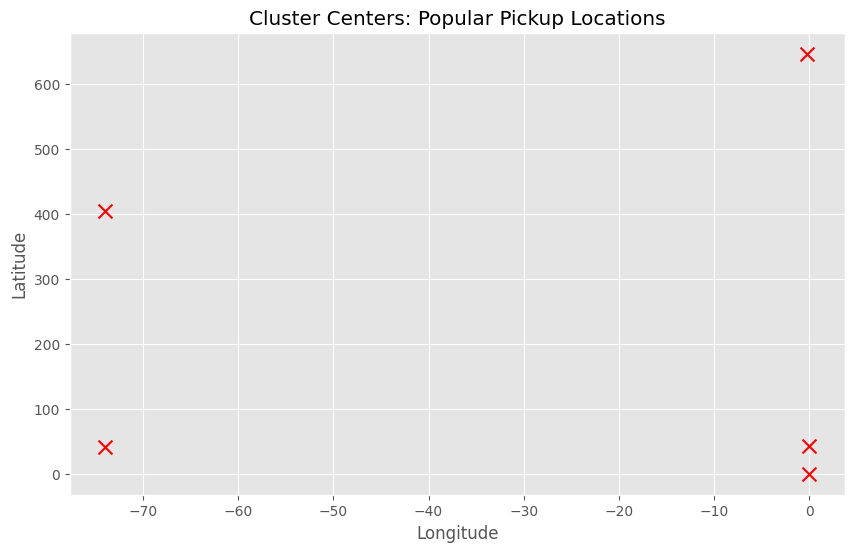

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert cluster centers to a Pandas DataFrame for easy plotting
centers_pd = pd.DataFrame(centers, columns=["longitude", "latitude"])

# Plot the cluster centers (popular pickup locations) on a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(centers_pd["longitude"], centers_pd["latitude"], c="red", s=100, marker="x")
plt.title("Cluster Centers: Popular Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [47]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In this cell, we create a heatmap to visualize pickup locations in New York City using the Folium library. We first convert the pickup latitude and longitude data into a list of coordinates. Then, we initialize a Folium map centered on New York City with a specified zoom level. We add a heatmap layer to the map using the pickup locations. Finally, we save the resulting map as an HTML file (nyc_pickup_heatmap.html), which can be opened in a web browser to explore the density of pickups across the city visually.

In [48]:
import folium
from folium.plugins import HeatMap

# Convert pickup locations to a list of [latitude, longitude]
pickup_locations = data_with_floats.select("pickup_latitude", "pickup_longitude").rdd.map(lambda row: [row[0], row[1]]).collect()

# Initialize a folium map centered at NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add heatmap to the map
HeatMap(pickup_locations).add_to(nyc_map)

# Show the map
nyc_map.save("nyc_pickup_heatmap.html")

In [49]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

# Assemble the feature vector using pickup_longitude and pickup_latitude
assembler = VectorAssembler(inputCols=["pickup_longitude", "pickup_latitude"], outputCol="features")

# Transform the data to include the features column
data_with_features = assembler.transform(data_with_floats)

# Standardize the features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(data_with_features)
scaled_data = scaler_model.transform(data_with_features)

# Show a sample of the scaled data
scaled_data.select("scaled_features").show(5, truncate=False)

+------------------------------------------+
|scaled_features                           |
+------------------------------------------+
|[-0.1351624153586362,0.12239289847410714] |
|[-0.13807723968266755,0.11787295883274997]|
|[-0.13787527619954176,0.11890635117830564]|
|[-0.13479825726357933,0.12273253570360186]|
|[-0.1349666901298155,0.12076250813019543] |
+------------------------------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import KMeans

# Initialize the KMeans model
kmeans = KMeans(k=5, seed=1, featuresCol="scaled_features")  # Use the scaled features
kmeans_model = kmeans.fit(scaled_data)

# Make predictions
clustered_data = kmeans_model.transform(scaled_data)

# Show the cluster assignments for each row
clustered_data.select("pickup_longitude", "pickup_latitude", "prediction").show(5)

# Get the cluster centers (the most popular pickup locations)
centers = kmeans_model.clusterCenters()
print("Cluster Centers: ", centers)

+----------------+---------------+----------+
|pickup_longitude|pickup_latitude|prediction|
+----------------+---------------+----------+
|      -73.978165|      40.757977|         0|
|       -74.00668|       40.73178|         0|
|       -74.00471|       40.73777|         0|
|        -73.9746|      40.759945|         0|
|       -73.97625|      40.748528|         0|
+----------------+---------------+----------+
only showing top 5 rows

Cluster Centers:  [array([-0.13465299,  0.12139133]), array([ 7.42592996, -6.9101397 ]), array([  7.40024291, 104.63025663]), array([7.4188224 , 0.32544383]), array([-0.13645529, 62.89464919])]
